In [8]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.optimize import minimize
import yfinance as yf
import time
import glob
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

folder_path = os.path.join("stocks", "datasets","dj30","raw", "*.csv")
csv_files = glob.glob(folder_path)
data_frames = []

for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    print(f"Processing {symbol} from {file}...")
    df = pd.read_csv(file, parse_dates=['Date'])
    mask = (df['Date'] >= '2010-01-01') & (df['Date'] <= '2019-12-21')
    df = df.loc[mask]
    df = df[['Date', 'Adj Close']].set_index('Date')
    df.rename(columns={'Adj Close': symbol}, inplace=True)
    data_frames.append(df)

merged_df = pd.concat(data_frames, axis=1)
merged_df.sort_index(inplace=True)

# Split data:
train_data = merged_df.loc['2010-01-01':'2016-01-01']
test_data  = merged_df.loc['2016-02-01':'2019-05-01']


train_log_returns = np.log(train_data / train_data.shift(1)).dropna()
window_size = 120
correlation_matrices = []
for start in range(0, len(train_log_returns) - window_size + 1, window_size):
    window_data = train_log_returns.iloc[start:start+window_size]
    corr_matrix = window_data.corr().values
    correlation_matrices.append(corr_matrix)

n_assets = train_log_returns.shape[1]
features = [mat[np.triu_indices(n_assets, k=1)] for mat in correlation_matrices]
features = np.array(features)

Z = linkage(features, method='ward')
n_clusters = 4
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

rep_corr_matrices = []
for cluster_id in range(1, n_clusters + 1):
    indices = np.where(clusters == cluster_id)[0]
    avg_corr = np.mean([correlation_matrices[i] for i in indices], axis=0)
    rep_corr_matrices.append(avg_corr)

annual_factor = 252
annual_drift = train_log_returns.mean() * annual_factor
annual_vol = train_log_returns.std() * np.sqrt(annual_factor)
mu = annual_drift.values
sigmas = annual_vol.values

S0s = train_data.iloc[-1].values

T = 1       # 1 year
dt = 1 / 252
n_steps = int(T / dt)

def simulate_correlated_prices(S0s, mu, sigmas, T, dt, corr_matrix):
    n_assets = len(S0s)
    n_steps = int(T / dt)
    prices = np.zeros((n_steps + 1, n_assets))
    prices[0] = S0s
    L = np.linalg.cholesky(corr_matrix)
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, size=n_assets)
        correlated_Z = L @ Z
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigmas**2) * dt + sigmas * np.sqrt(dt) * correlated_Z)
    return prices

def simulate_multiple_paths(S0s, mu, sigmas, T, dt, corr_matrix, num_paths=1000):
    sims = []
    for _ in range(num_paths):
        sim = simulate_correlated_prices(S0s, mu, sigmas, T, dt, corr_matrix)
        sims.append(sim)
    return np.array(sims)

all_simulations = {}
num_paths = 1000
for idx, corr in enumerate(rep_corr_matrices):
    sims = simulate_multiple_paths(S0s, mu, sigmas, T, dt, corr, num_paths=num_paths)
    all_simulations[idx] = sims

combined_simulations = np.concatenate(list(all_simulations.values()), axis=0)
dummy_dates = pd.date_range(start="2018-01-01", periods=combined_simulations.shape[1], freq="B")
asset_names = [f"Stock{i+1}" for i in range(combined_simulations.shape[2])]
train_episode_df = pd.DataFrame(combined_simulations[np.random.choice(combined_simulations.shape[0])],
                                index=dummy_dates, columns=asset_names)

class PortfolioEnv:
    def __init__(self, price_data, window_obs=60, window_state=120):
        self.price_data = price_data.reset_index(drop=True)
        self.window_obs = window_obs
        self.window_state = window_state
        self.n_assets = price_data.shape[1]
        self.reset()

    def reset(self):
        self.current_step = max(self.window_obs, self.window_state)
        self.done = False
        self.portfolio_value = 1.0
        self.history = [self.portfolio_value]
        self.weights = np.ones(self.n_assets) / self.n_assets
        return self._get_state()

    def step(self, action):
        self.weights = action
        current_prices = self.price_data.iloc[self.current_step].values
        next_prices = self.price_data.iloc[self.current_step+1].values
        asset_returns = (next_prices / current_prices) - 1
        portfolio_return = np.dot(self.weights, asset_returns)
        self.portfolio_value *= (1 + portfolio_return)
        self.history.append(self.portfolio_value)
        self.current_step += 1
        if self.current_step >= len(self.price_data)-1:
            self.done = True
        reward = portfolio_return
        return self._get_state(), reward, self.done, {}

    def _get_state(self):
        obs_data = self.price_data.iloc[self.current_step - self.window_obs:self.current_step]
        obs_returns = np.log(obs_data / obs_data.shift(1)).dropna().values # pas besoin de transposer
        
        if obs_returns.shape[0] < self.window_obs - 1:  # -1 car nous perdons une observation avec diff
            pad = np.zeros((self.window_obs - 1 - obs_returns.shape[0], self.n_assets))
            obs_returns = np.vstack((obs_returns, pad))
        
        hist = np.array(self.history)
        if len(hist) < self.window_state+1:
            state_data = np.log(hist[1:] / hist[:-1])
            state_data = np.pad(state_data, (self.window_state - len(state_data), 0), 'constant')
        else:
            window_hist = hist[-(self.window_state+1):]
            state_data = np.log(window_hist[1:] / window_hist[:-1])
        obs_tensor = torch.tensor(obs_returns, dtype=torch.float32).unsqueeze(0)  
        state_tensor = torch.tensor(state_data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)  
        
        return (obs_tensor, state_tensor)

    def render(self):
        plt.plot(self.history)
        plt.title("Portfolio Value")
        plt.show()

def generate_actions(n_assets, n_actions=50):
    actions = []
    for _ in range(n_actions):
        w = np.random.rand(n_assets)
        w = w / w.sum()
        actions.append(w)
    return np.array(actions)

actions = generate_actions(train_episode_df.shape[1], n_actions=100)

class RLPortfolioManager(nn.Module):
    def __init__(self, obs_channels, obs_length, state_channels, state_length, num_actions):
        super(RLPortfolioManager, self).__init__()
        # LSTM pour les observations d'actifs -> on change input_size
        self.obs_lstm = nn.LSTM(
            input_size=obs_channels,  # Nb d'actifs
            hidden_size=64, 
            num_layers=2, 
            batch_first=True,
            dropout=0.1
        )
        self.fc_obs = nn.Linear(64, 128)
        
        # LSTM pour l'historique de l'état du portfolio
        self.state_lstm = nn.LSTM(
            input_size=state_channels, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True,
            dropout=0.1
        )
        self.fc_state = nn.Linear(32, 128)
        
        # Couches combinés et head de sortie
        self.fc_combined = nn.Linear(128 + 128, 128)
        self.policy_head = nn.Linear(128, num_actions)
        self.value_head = nn.Linear(128, 1)

    def forward(self, observation, state):
        # (batch, seq_len, features)
        obs_output, _ = self.obs_lstm(observation)
        # On prend le dernier état caché
        obs_features = obs_output[:, -1, :]
        obs_features = F.relu(self.fc_obs(obs_features))
        
        # Traitement de l'état du portefeuille avec LSTM
        state_output, _ = self.state_lstm(state)
        state_features = state_output[:, -1, :]
        state_features = F.relu(self.fc_state(state_features))
        
        # Combinaison et output
        combined = torch.cat([obs_features, state_features], dim=1)
        combined = F.relu(self.fc_combined(combined))
        policy_logits = self.policy_head(combined)
        value = self.value_head(combined)
        
        return policy_logits, value

obs_channels = train_episode_df.shape[1]  
obs_length = 59  # 60-1 car on perd une observation avec le calcul des rendements
state_channels = 1  
state_length = 120  
num_actions = actions.shape[0]

policy_net = RLPortfolioManager(obs_channels, obs_length, state_channels, state_length, num_actions)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

def train_agent(policy_net, optimizer, actions, combined_simulations, num_episodes=500, window_obs=60, window_state=120, gamma=0.99):
    episode_returns = []
    
    for ep in range(num_episodes):
        episode_idx = np.random.choice(combined_simulations.shape[0])
        dummy_dates = pd.date_range(start="2018-01-01", periods=combined_simulations.shape[1], freq="B")
        asset_names = [f"Stock{i+1}" for i in range(combined_simulations.shape[2])]
        train_episode_df = pd.DataFrame(combined_simulations[episode_idx],
                                       index=dummy_dates, columns=asset_names)

        env = PortfolioEnv(train_episode_df, window_obs=window_obs, window_state=window_state)
        state = env.reset()

        log_probs = []
        values = []
        rewards = []
        entropies = []  # Pour encourager l'exploration
        done = False

        while not done:
            obs, port_state = state
            policy_logits, value = policy_net(obs, port_state)
            probs = F.softmax(policy_logits, dim=1)
            m = torch.distributions.Categorical(probs)
            action_idx = m.sample()
            log_prob = m.log_prob(action_idx)
            entropy = m.entropy()  # Calcul de l'entropie pour la régularisation
            value = value.squeeze(1)
            action = actions[action_idx.item()]

            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            entropies.append(entropy)
            state = next_state

        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)
        
        values = torch.stack(values).squeeze(-1)
        log_probs = torch.stack(log_probs)
        entropies = torch.stack(entropies)

        advantage = returns - values.detach()
        
        # Normalisation de l'avantage pour stabilité
        if len(advantage) > 1:
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
            
        policy_loss = -(log_probs * advantage).mean()
        value_loss = F.mse_loss(values, returns)
        entropy_loss = -entropies.mean() * 0.01  # Coefficient d'entropie
        
        # Perte totale
        loss = policy_loss + 0.5 * value_loss + entropy_loss

        optimizer.zero_grad()
        loss.backward()
        
        # Clip des gradients pour éviter l'explosion
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=0.5)
        
        optimizer.step()
        
        episode_return = np.prod([1 + r for r in rewards]) - 1
        episode_returns.append(episode_return)
        
        if (ep + 1) % 10 == 0:
            avg_return = np.mean(episode_returns[-10:])
            print(f"Episode {ep+1}/{num_episodes}, Loss: {loss.item():.4f}, Avg Return (last 10): {avg_return:.4f}")

    return policy_net

trained_policy = train_agent(policy_net, optimizer, actions, combined_simulations, num_episodes=500)
#################test############################
env_test = PortfolioEnv(test_data, window_obs=60, window_state=120)

def test_agent(env, policy_net, actions):
    state = env.reset()
    done = False
    test_rewards = []
    while not done:
        obs, port_state = state
        with torch.no_grad():
            policy_logits, _ = policy_net(obs, port_state)
            probs = F.softmax(policy_logits, dim=1)
        action_idx = torch.argmax(probs, dim=1)
        action = actions[action_idx.item()]
        state, reward, done, _ = env.step(action)
        test_rewards.append(reward)
    total_return = np.prod([1 + r for r in test_rewards])
    return total_return

rl_test_return = test_agent(env_test, trained_policy, actions)
print("RL test return:", rl_test_return)

# Define evaluation intervals entirely within the test period.
intervals = [("2016-02-01", "2017-01-01"),
             ("2017-01-01", "2018-02-01"),
             ("2018-02-01", "2019-03-01")]

def sharpe_ratio(rewards, risk_free_rate=0.04, periods_per_year=252):
    rewards = np.array(rewards)
    mean_return = np.mean(rewards)
    std_return = np.std(rewards)
    if std_return == 0:
        return np.nan
    return mean_return / std_return * np.sqrt(periods_per_year)

def test_agent_with_rewards(env, policy_net, actions):
    state = env.reset()
    done = False
    rewards = []
    while not done:
        obs, port_state = state
        with torch.no_grad():
            policy_logits, _ = policy_net(obs, port_state)
            probs = F.softmax(policy_logits, dim=1)
        action_idx = torch.argmax(probs, dim=1)
        action = actions[action_idx.item()]
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
    total_return = np.prod([1 + r for r in rewards])
    return total_return, rewards

def simulate_benchmark(env, weights):
    state = env.reset()
    done = False
    rewards = []
    while not done:
        state, reward, done, _ = env.step(weights)
        rewards.append(reward)
    total_return = np.prod([1 + r for r in rewards])
    return total_return, rewards

def optimize_portfolio(mu, cov):
    n = len(mu)
    w0 = np.ones(n) / n
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(n)]
    def neg_sharpe(w, mu, cov):
        port_return = np.dot(w, mu)
        port_std = np.sqrt(np.dot(w, np.dot(cov, w)))
        return -port_return / port_std if port_std > 0 else 1e6
    result = minimize(neg_sharpe, w0, args=(mu, cov), bounds=bounds, constraints=constraints)
    return result.x if result.success else w0

results = {}

for start, end in intervals:
    interval_df = test_data.loc[start:end].copy()
    window_obs = 60
    window_state = 120
    if len(interval_df) < (window_obs + 1):
        print(f"Interval {start} to {end} is too short. Skipping.")
        continue
    env_interval = PortfolioEnv(interval_df, window_obs=window_obs, window_state=window_state)

    # RL Agent evaluation:
    rl_total_return, rl_rewards = test_agent_with_rewards(env_interval, trained_policy, actions)
    rl_sharpe = sharpe_ratio(rl_rewards)

    # MVO Benchmark:
    returns = np.log(interval_df / interval_df.shift(1)).dropna()
    mu_interval = returns.mean().values
    cov_interval = returns.cov().values
    mvo_weights = optimize_portfolio(mu_interval, cov_interval)
    mvo_total_return, mvo_rewards = simulate_benchmark(env_interval, mvo_weights)
    mvo_sharpe = sharpe_ratio(mvo_rewards)

    # Equal Weights Benchmark:
    n_assets = interval_df.shape[1]
    equal_weights = np.ones(n_assets) / n_assets
    equal_total_return, equal_rewards = simulate_benchmark(env_interval, equal_weights)
    equal_sharpe = sharpe_ratio(equal_rewards)

    # results
    results[(start, end)] = {
        "RL": {
            "Total Return": rl_total_return,
            "Sharpe": rl_sharpe,
            "Rewards": rl_rewards
        },
        "MVO": {
            "Total Return": mvo_total_return,
            "Sharpe": mvo_sharpe,
            "Rewards": mvo_rewards
        },
        "Equal_weights": {
            "Total Return": equal_total_return,
            "Sharpe": equal_sharpe,
            "Rewards": equal_rewards
        }
    }

    print(f"Interval {start} to {end}:")
    print(f"  RL     - Total Return: {rl_total_return:.4f}, Sharpe Ratio: {rl_sharpe:.4f}")
    print(f"  MVO - Total Return: {mvo_total_return:.4f}, Sharpe Ratio: {mvo_sharpe:.4f}")
    print(f"  Equal Weights - Total Return: {equal_total_return:.4f}, Sharpe Ratio: {equal_sharpe:.4f}")
    print("---------------------------------------------------")

Processing CSCO from CSCO.csv...
Processing AXP from AXP.csv...
Processing AAPL from AAPL.csv...
Processing MRK from MRK.csv...
Processing V from V.csv...
Processing BA from BA.csv...
Processing TRV from TRV.csv...
Processing UNH from UNH.csv...
Processing DIS from DIS.csv...
Processing IBM from IBM.csv...
Processing HON from HON.csv...
Processing AMGN from AMGN.csv...
Processing KO from KO.csv...
Processing MCD from MCD.csv...
Processing CVX from CVX.csv...
Processing NKE from NKE.csv...
Processing MMM from MMM.csv...
Processing MSFT from MSFT.csv...
Processing PG from PG.csv...
Processing GS from GS.csv...
Processing WMT from WMT.csv...
Processing CRM from CRM.csv...
Processing WBA from WBA.csv...
Processing VZ from VZ.csv...
Processing JPM from JPM.csv...
Processing CAT from CAT.csv...
Processing INTC from INTC.csv...
Processing JNJ from JNJ.csv...
Processing HD from HD.csv...
Episode 10/500, Loss: -0.0454, Avg Return (last 10): 0.0048
Episode 20/500, Loss: -0.0422, Avg Return (last

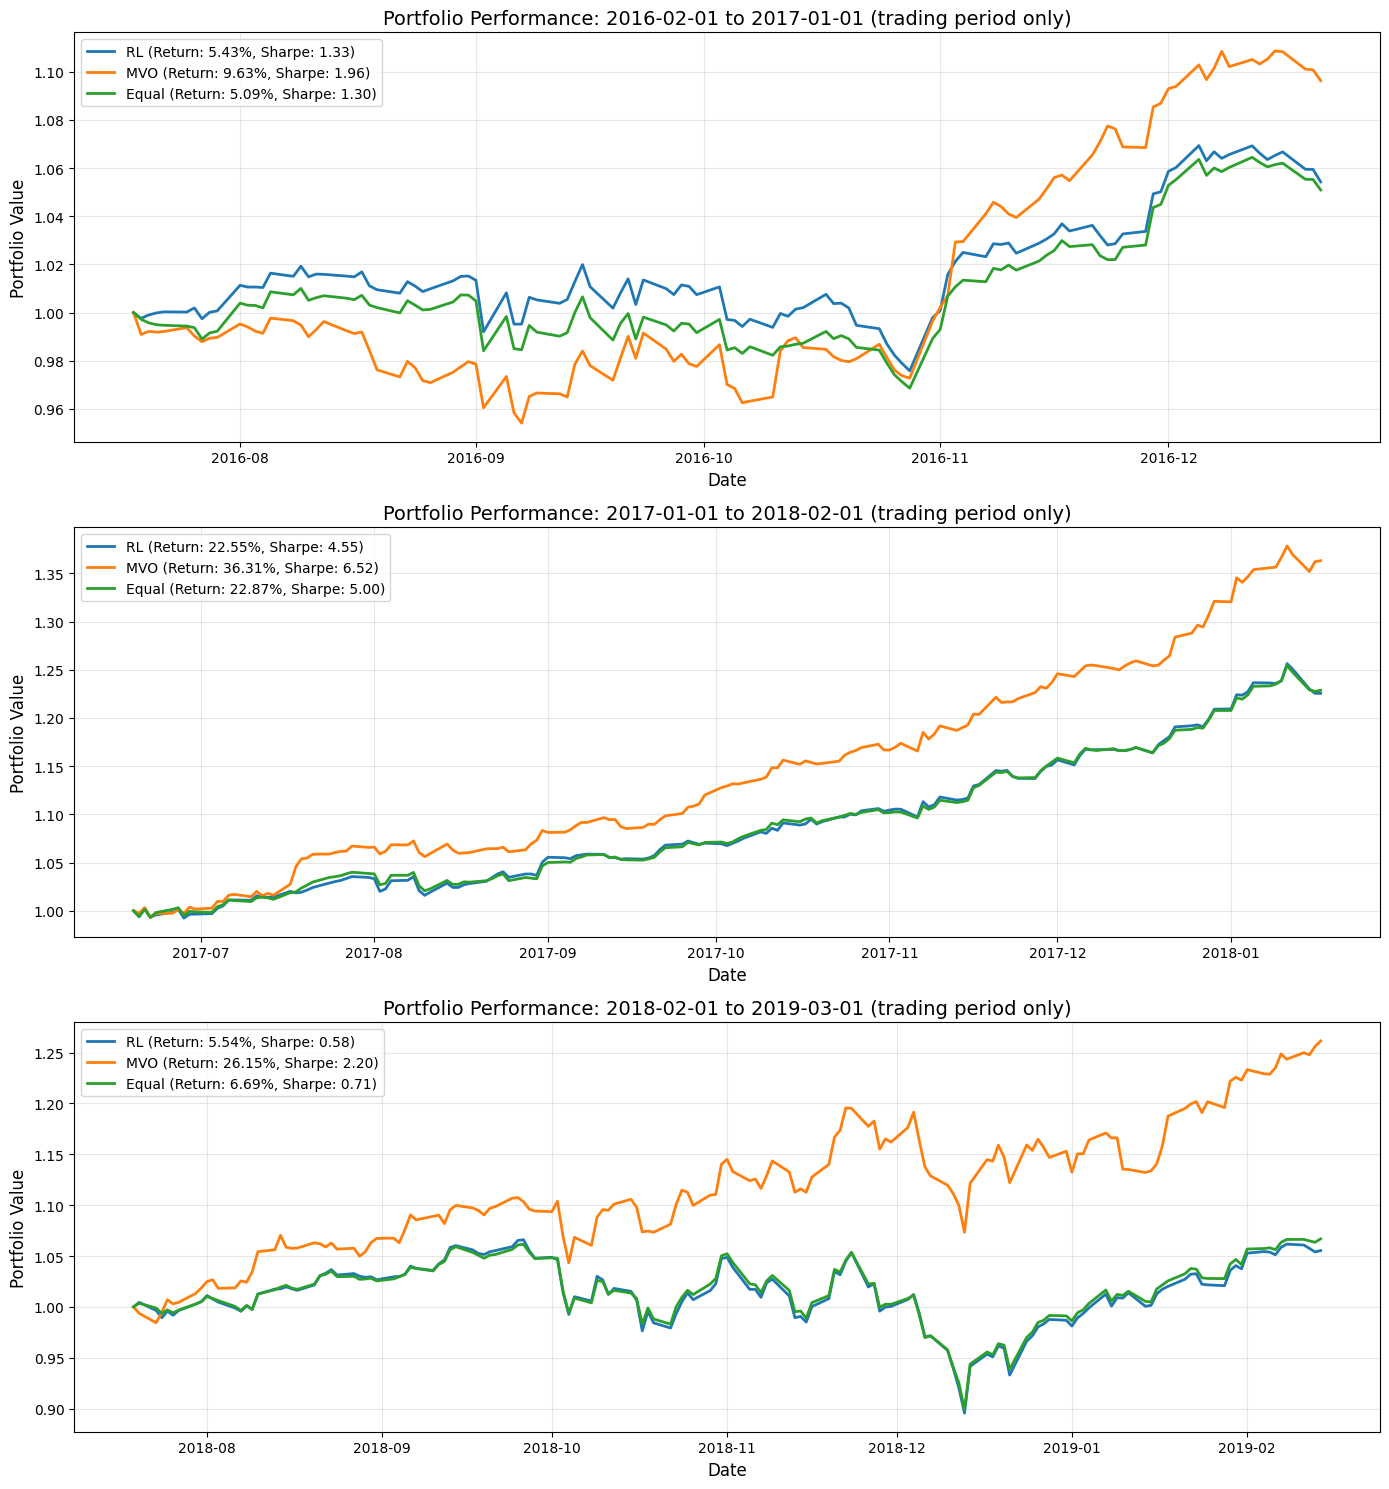

In [ ]:
def visualize_performance_comparison_trading_only(historical_df, intervals, results):
    """
    Visualise la performance à partir du moment où le trading commence réellement (après la période d'observation de 120 jours)
    """
    fig, axs = plt.subplots(len(intervals), 1, figsize=(14, 5*len(intervals)))

    if len(intervals) == 1:
        axs = [axs]  

    # période d'observation (en jours ouvrables)
    OBSERVATION_PERIOD = 120

    for i, (start, end) in enumerate(intervals):
        ax = axs[i]

        interval_df = historical_df.loc[start:end].copy()

        if (start, end) not in results:
            print(f"Intervalle {start} à {end} non trouvé dans les résultats.")
            continue

        # performances cumulées
        result = results[(start, end)]

        rl_returns = result["RL"]["Rewards"]
        mvo_returns = result["MVO"]["Rewards"]
        equal_returns = result["Equal_weights"]["Rewards"]

        # valeur du portefeuille
        rl_performance = np.cumprod(np.array([1.0] + [1 + r for r in rl_returns]))
        mvo_performance = np.cumprod(np.array([1.0] + [1 + r for r in mvo_returns]))
        equal_performance = np.cumprod(np.array([1.0] + [1 + r for r in equal_returns]))

        # Estimer la date réelle de début de trading
        full_date_range = pd.date_range(start=start, end=end, freq='B')
        if len(full_date_range) > OBSERVATION_PERIOD:
            trading_start_date = full_date_range[OBSERVATION_PERIOD]
        else:
            trading_start_date = full_date_range[0]  # Fallback si l'intervalle est trop court

        performance_dates = pd.date_range(start=trading_start_date, periods=len(rl_performance), freq='B')

        ax.plot(performance_dates, rl_performance, label='RL Strategy', linewidth=2)
        ax.plot(performance_dates, mvo_performance, label='MVO Strategy', linewidth=2)
        ax.plot(performance_dates, equal_performance, label='Equal Weights', linewidth=2)

        # fin réelle de la période de trading
        trading_end_date = performance_dates[-1]

        trading_start_str = trading_start_date.strftime('%Y-%m-%d')
        trading_end_str = trading_end_date.strftime('%Y-%m-%d')

        rl_sharpe = result["RL"]["Sharpe"]
        mvo_sharpe = result["MVO"]["Sharpe"]
        equal_sharpe = result["Equal_weights"]["Sharpe"]

        rl_final_return = rl_performance[-1] - 1
        mvo_final_return = mvo_performance[-1] - 1
        equal_final_return = equal_performance[-1] - 1

        ax.legend([
            f'RL (Return: {rl_final_return:.2%}, Sharpe: {rl_sharpe:.2f})',
            f'MVO (Return: {mvo_final_return:.2%}, Sharpe: {mvo_sharpe:.2f})',
            f'Equal (Return: {equal_final_return:.2%}, Sharpe: {equal_sharpe:.2f})'
        ])

        ax.set_title(f'Portfolio Performance: {start} to {end} (trading period only)', fontsize=14)
        ax.set_ylabel('Portfolio Value', fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.grid(True, alpha=0.3)

        rl_dd = calculate_drawdown(rl_performance)
        max_dd_idx = np.argmax(rl_dd)
        if rl_dd[max_dd_idx] > 0.05:  # Si le drawdown est significatif
            ax.scatter(performance_dates[max_dd_idx], rl_performance[max_dd_idx],
                      color='red', s=100, zorder=5)
            ax.annotate(f'Max DD: {rl_dd[max_dd_idx]:.2%}',
                       (performance_dates[max_dd_idx], rl_performance[max_dd_idx]),
                       xytext=(15, -20), textcoords='offset points',
                       arrowprops=dict(arrowstyle='->', color='red'))

    plt.tight_layout()
    plt.savefig('trading_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def calculate_drawdown(equity_curve):
    hwm = np.zeros_like(equity_curve)  # high water mark
    hwm[0] = equity_curve[0]

    for i in range(1, len(equity_curve)):
        hwm[i] = max(hwm[i-1], equity_curve[i])

    drawdown = (equity_curve / hwm) - 1
    return drawdown

visualize_performance_comparison_trading_only(test_data, intervals, results)